Mitch's example of something we would expect to receive from our students

In [1]:
import pandas as pd
import numpy as np
from collections import Counter
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier

plt.style.use("ggplot")
%matplotlib inline

In [2]:
mush_data = pd.read_csv('mushrooms.csv', dtype="category")
# We can drop every column that is unique, since it will not affect classification
mush_data = mush_data.drop(mush_data.columns[mush_data.describe().loc['unique'] == 1], axis=1)

In [3]:
mush_data.describe()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-color,ring-number,ring-type,spore-print-color,population,habitat
count,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,...,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124
unique,2,6,4,10,2,9,2,2,2,12,...,4,4,9,9,4,3,5,9,6,7
top,e,x,y,n,f,n,f,c,b,b,...,s,s,w,w,w,o,p,w,v,d
freq,4208,3656,3244,2284,4748,3528,7914,6812,5612,1728,...,5176,4936,4464,4384,7924,7488,3968,2388,4040,3148


In [4]:
# Convert the columns into numbers so that .fit will work properly
for column in mush_data.columns:
    mush_data[column] = mush_data[column].astype("category").cat.codes

In [5]:
train, test = train_test_split(mush_data, train_size=.7, test_size=.3)
trainX, testX = train.drop("class", axis=1), test.drop("class", axis=1)
trainY, testY = train['class'], test['class']

forest = RandomForestClassifier()
forest.fit(trainX, trainY)

predY = forest.predict(testX)
print(classification_report(testY, predY))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00      1246
          1       1.00      1.00      1.00      1192

avg / total       1.00      1.00      1.00      2438



We see that we achieve 100% accuracy when using all of the columns available, but do we really need to use all of the top features in order to classify these mushrooms?

# Finding Maximal Features

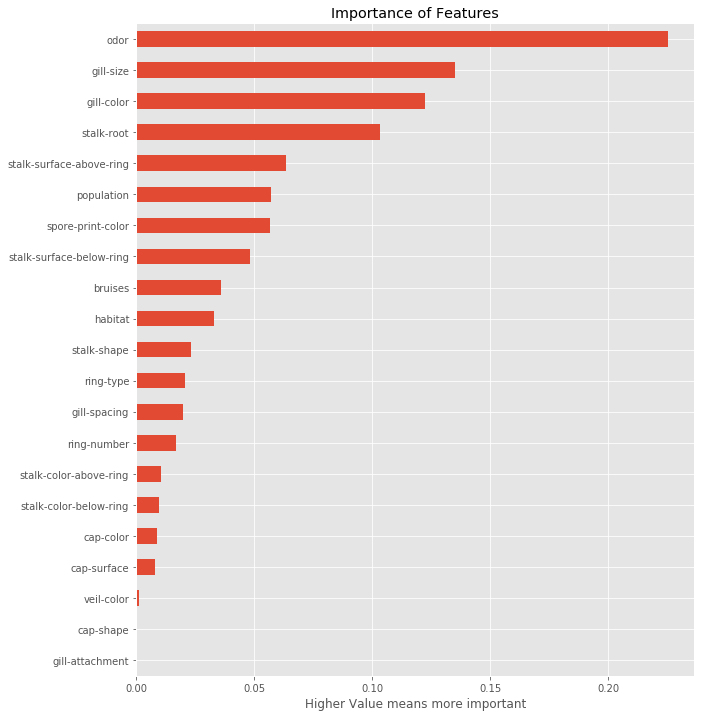

In [6]:
weight = pd.DataFrame(forest.feature_importances_, index=trainX.columns)
weight[0].sort_values().plot(kind="barh", figsize=(10,12))
plt.title("Importance of Features")
plt.xlabel("Higher Value means more important")
plt.show()

We know that there are 21 columns of classification data, let's use the 10 most important and see if that can still give us total accuracy:

In [8]:
top10 = list(weight.head(10).index)
train, test = train_test_split(mush_data)
trainX, testX = train.drop("class", axis=1)[top10], test.drop("class", axis=1)[top10]
trainY, testY = train['class'], test['class']

forest = RandomForestClassifier()
forest.fit(trainX, trainY)

pred_y = forest.predict(testX)
print(classification_report(testY, pred_y))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00      1057
          1       1.00      0.99      1.00       974

avg / total       1.00      1.00      1.00      2031



Success! It looks like we have been able to successfully classify all of our mushrooms using just the top 10 most important features of our mushroom. However, repeated runs show that the most important feature is changed depending on how the data gets split, sometimes **odor** is at the top, and other times **gill-color** or **gill-size** is number one, and on rare occassions **population** or **spore-print-color** comes up as the top feature.

In [9]:
def run_simulation():
    """Runs a RandomForestClassifier on all of the data and returns the features in order of most importance.
    Built to test how often a feature is at the top, middle, or bottom"""
    train, test = train_test_split(mush_data, train_size=.7, test_size=.3)
    trainX, testX = train.drop("class", axis=1), test.drop("class", axis=1)
    trainY, testY = train['class'], test['class']

    forest = RandomForestClassifier()
    forest.fit(trainX, trainY)
    weight = pd.DataFrame(forest.feature_importances_, index=trainX.columns)
    return list(weight[0].sort_values(ascending=False).index)

In [10]:
values = {key:0 for key in train.drop("class", axis=1).columns}
N = 1000
for i in range(N):
    # Perform 500 simulations of our RandomForestClassifier
    order = run_simulation()
    for i,col in enumerate(order):
        # Record the ranking that each column got, the lower the better
        values[col] += (i+1)
        
# Show the ranking from best to worst
average_order = Counter({key:value/N for key,value in values.items()})
average_order.most_common()[::-1]

[('odor', 2.228),
 ('gill-size', 3.254),
 ('gill-color', 3.717),
 ('spore-print-color', 4.315),
 ('ring-type', 6.47),
 ('stalk-root', 7.109),
 ('population', 7.315),
 ('bruises', 8.692),
 ('stalk-surface-above-ring', 9.23),
 ('gill-spacing', 9.596),
 ('stalk-surface-below-ring', 9.683),
 ('habitat', 10.95),
 ('stalk-shape', 12.943),
 ('stalk-color-below-ring', 14.787),
 ('stalk-color-above-ring', 14.906),
 ('cap-color', 14.987),
 ('ring-number', 15.555),
 ('cap-surface', 16.616),
 ('cap-shape', 18.889),
 ('veil-color', 19.756),
 ('gill-attachment', 20.002)]

Here we see that **odor** is the most prominent feature on average, receiving an average ranking of 2.228, much better than **gill-size**, and **gill-color**, the order of this list is an accurate representation of the order of importance for each feature. Take this list back to the CCC and let them know that we were able to successfully classify the mushrooms using RandomForestClassification

# My Final Thoughts:

I spent two hours preparing this spell. It took a little less than an hour to get all of the basic code working, including plotting the features sorted. The second hour was spent figuring out how to deal with the fact that the important features changed with repeated runs.

How was I supposed to know that I could call .cat.codes on the data in order to give them numerical? I googled the error I was getting when I didn't do that (ValueError: could not convert string to float), and this answer https://stackoverflow.com/questions/30384995/randomforestclassfier-fit-valueerror-could-not-convert-string-to-float told me to use pd.get_dummies(df) in order to split the data into separate columns. I got 100% classification from it but it made my feature importance nonsense, there were lots of zeroes and other negatives, but no positives.

I read something about the difference between ordered categorical data and unordered categorical data, I got the impression that ordered categorical data is almost like doing bands, but I'm not sure. How much does this need to be addressed, if at all?

Recognizing that you can eliminate all of the categories that only have one classification was REALLY cool. I didn't get that on my own, I got that after I read through your notebook. Wow!! It's so obvious but it still blew my mind.

Can we expect students to recognize that repeated runs are going to change the order of importance for features? It took me a bit to figure out myself, what should they do about it? I imagine they'll want to check their answers with each other and they won't be the same. I was somewhat surprised to see how much it changed. Perhaps this can be hinted at in the instruction? Also, the sklearn page was simple enough to learn how \_feature\_importances\_ worked, I had zero troubles with that

I chose my method to rank the features in order of importance, but it seems to me like k-fold validation might actually be a better method, that way it's ensured that we get different data.